# read data + dummies + nan to mean

In [13]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [3]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

In [4]:
# дамми фичи
train_df = pd.concat([train_df.drop(columns=['ul_staff_range']), pd.get_dummies(data=train_df['ul_staff_range'])], axis=1)
test_df = pd.concat([test_df.drop(columns=['ul_staff_range']), pd.get_dummies(data=test_df['ul_staff_range'])], axis=1)

In [5]:
train_cols = train_df.columns
test_cols = test_df.columns

In [6]:
# замена нан значений на стреднее
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
train_df = pd.DataFrame(imp_mean.fit_transform(train_df), columns=train_cols)
test_df = pd.DataFrame(imp_mean.fit_transform(test_df), columns=test_cols)

здесь я решил немного уменьшить количество фичей за счет удаления тех, которые, как я полагаю, не вносили сильного вклада в предикт

- во первых, среди них точно была одна-две константные фичи, очевидно смылса в них нет
- во вторых, фичи, имеющие "одинаковую картину" для обоих классов - если вывести dots график зависимости таргета от таких фичей, то полоски из точек что у 0, что у 1, будут одинаковыми
- от record_id при обучении тоже решил отказаться, полагаю, это просто индекс 

In [7]:
to_drop = ['record_id', 'ul_systematizing_flg', 'ul_strategic_flg', 'ul_branch_cnt', 'cap_actual_age',
          'head_actual_age', 'adr_actual_age', 'ogrn_age', 'bus_age']
train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)

Я немного поперебирал оставшиеся фичи, выбрал пару, показанную ниже, так как она мне показалась наиболее подходящей для повествования: примерно такая же картина у всех пар фичей - превалирующий класс как-то распределен, и среди него "вкраплениями" встречаются объекты меньшего класса.

Полагаю, по этой причине линейная модель показала себя не очень хорошо при тестах в первом ноутбуке.
Вместе с этим кажется приходит понимание, почему лучше всего сработал knn и простой oversampling: "картина" взаимного расположения объектов классов остается та же, однако за счет копирования на месте одной точки могут находиться несколько объектов класса 1 (за счет того что knn запоминает выборку), и при определенном значении n_neighbors можно получить качество по-лучше.

Ниже я решил протестировать одну пришедшую мне в голову идею со SMOTE оверсемплингом: в этой паре фичей объекты меньшего класса встречаются лишь в небольшой зоне покрытия бОльшего класса, так что если применить SMOTE, можно получить что-то похожее на ситуацию ниже, с чем вроде как должен справляться knn

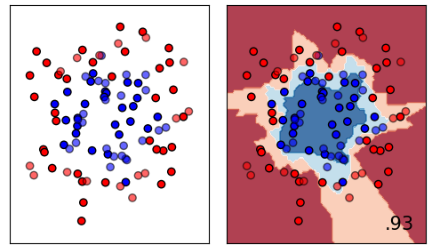

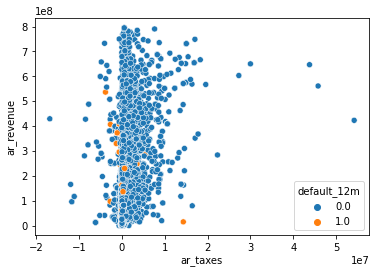

In [32]:
sns.scatterplot(data=train_df, x='ar_taxes', y='ar_revenue', hue='default_12m')

In [33]:
data = train_df[['ar_taxes', 'ar_revenue', 'default_12m']]

In [34]:
sm = SMOTE()
x, y = sm.fit_resample(data.drop(columns=['default_12m']), data['default_12m'])

In [35]:
data = pd.concat([x, y], axis=1)

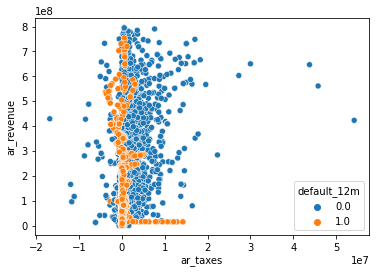

In [36]:
sns.scatterplot(data=data, x='ar_taxes', y='ar_revenue', hue='default_12m')

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=20, weights='distance'), x, y, scoring='accuracy'))

0.5966043965660506

Как можем заметить, в тестах в первом ноутбуке качество knn стартовало с 66% и доходило до 90%, здесь же в среднем 60%, однако это не совсем походит на ситуацию на закрытом датасете, как покажет сабмит ниже

In [59]:
clf = KNeighborsClassifier(n_neighbors=20, weights='distance')
clf.fit(x, y)

KNeighborsClassifier(n_neighbors=20, weights='distance')

In [60]:
test = test_df[['ar_taxes', 'ar_revenue']]
preds = clf.predict(test)

In [67]:
preds = pd.DataFrame(preds, columns=['predict'])

In [76]:
dop = pd.DataFrame(pd.read_csv('PD-data-test.csv', sep=';')['record_id'])

In [79]:
res = pd.concat([dop, preds], axis=1).rename(columns={'record_id': 'id'})

In [81]:
res.to_csv('knn_extr_feature.csv',index=False, sep=';')

Скор оказался 0.525, несколько лучше линейной модели, но и не то  что бы хорошо

# Заключение

Попарный анализ некоторых фичей помог мне лучше увидеть, что представляют из себя данные в это соревновании. Честно, не совсем уверен, действительно ли тут может помочь ребалансировка классов.